# START HERE

## 4. Building a Predictive Model

In [68]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay # want the ones with false neg not positives
from sklearn.metrics import recall_score, precision_score, roc_auc_score, plot_roc_curve, roc_curve, auc, RocCurveDisplay

from matplotlib import pyplot as plt
# import seaborn as sns
from sklearn import set_config # for plotting pipeline

import pickle


In [69]:
# Load data
df = pd.read_csv("data/data.csv") 

# # REMOVE any rows with more than one null for training 
to_drop = df[df.isnull().sum(axis=1) >1].index.tolist()
df = df.drop(to_drop)

# Note this removes 13 rows
df.shape

(601, 13)

In [70]:
# Remove outliers 
def remove_outliers(df, cols):
#     cols = ['Total_Income_log']#, 'LoanAmt_Term_Ratio_Log', 'LoanAmountLog'] 
    Q1 = df[cols].quantile(0.25)
    Q3 = df[cols].quantile(0.75)
    IQR = Q3 - Q1
#     df = df[~((df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
    df = df[~((df[cols] > (Q3 + 2 * IQR))).any(axis=1)]
    return df

df = remove_outliers(df, ['ApplicantIncome', 'LoanAmount'])
df.shape


(552, 13)

In [71]:
# # DEBUG IMPUTER 
# df.dropna(inplace=True)

In [72]:
# Separate out target, and drop id column
X = df.drop(columns=['Loan_Status','Loan_ID'])
y = df['Loan_Status'].replace({'Y':1, 'N':0})

# Test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=88)

In [73]:
# Split into cat_feats and num_feats
cat_feats = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area']
num_feats = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

def numFeat(data):
    return data[num_feats]

def catFeat(data):
    return data[cat_feats]

keep_num = FunctionTransformer(numFeat)
keep_cat = FunctionTransformer(catFeat)

# Note: Loan amount term is really more categorical, but leaving as numeric so can use in calculations - and will scale
# Credit history will need to be converted to categorical

In [82]:
# Add new columns
def replace_income_with_total_income_log(X):
    X['Total_Income_Log'] = np.log(X['ApplicantIncome'] + X['CoapplicantIncome'])
    X.drop(labels=['ApplicantIncome','CoapplicantIncome'], axis=1, inplace=True)
    return X

def add_LoanAmt_Term_Ratio_Log(X):
    X['LoanAmt_Term_Ratio_Log']=  np.log(X.LoanAmount/X.Loan_Amount_Term)
    return X

def replace_loanamount_with_loanamount_log(X):
    X['LoanAmount_Log'] = np.log(X.LoanAmount)
    X = X.drop(labels=['LoanAmount'], axis=1, inplace=True)
    return X

def inject_features(data):
    data['Total_Income_Log'] = np.log(data['ApplicantIncome'] + data['CoapplicantIncome'])
    data['LoanAmt_Term_Ratio_Log']=  np.log(data['LoanAmount']/data['Loan_Amount_Term'])
    data['LoanAmount_Log'] = np.log(data['LoanAmount'])
    data.drop(labels=['ApplicantIncome','CoapplicantIncome', 'LoanAmount'], axis=1, inplace=True)
    data.reset_index(inplace=True)
    return data

injected = FunctionTransformer(inject_features)

add_total_income_log_object = FunctionTransformer(replace_income_with_total_income_log)
add_loanamt_term_ratio_log_object = FunctionTransformer(add_LoanAmt_Term_Ratio_Log)
add_loanamount_log_object = FunctionTransformer(replace_loanamount_with_loanamount_log)

In [83]:
# One hot encode # only a portion of the categorical 
enc = OneHotEncoder(sparse=False)

In [84]:
# PCA - reduce dummy variables of catigorical?? or all>
pca = PCA(n_components=3)

In [85]:
# kbest - right now just on numeric 
selection = SelectKBest(k=3)

Try paramater grid search to improve the results

In [86]:
# PCA/ kbest - do together after? or separately?

In [87]:
# test with p-value <0.05, sensitivity and specifity , AUC and ROC

## 5. Using Pipeline
If you didn't use pipelines before, transform your data prep, feat. engineering and modeling steps into Pipeline. It will be helpful for deployment.

The goal here is to create the pipeline that will take one row of our dataset and predict the probability of being granted a loan.

`pipeline.predict(x)`

In [ ]:
# THE FOLLOWING COMMENTED OUT BLOCKS ARE SUGGESTIONS FOR MY FUTURE REFERENCE - PLEASE DISREGARD

# fillna_trans = ColumnTransformer([
#      ('fillna_mode', SimpleImputer(strategy="most_frequent"), ['Gender','Dependents']),
#      ('fillna_No', SimpleImputer(strategy='constant', fill_value='No'), ['Married', 'Self_Employed']),
#      ('fillna_mean', SimpleImputer(strategy='mean'), ['LoanAmount','Loan_Amount_Term']),
#      ('fillna_zero', SimpleImputer(strategy='constant',fill_value=0), ['Credit_History'])],
#      remainder='passthrough')

In [ ]:
# preprocess_pipeline = make_pipeline(   
#     FeatureUnion(transformer_list=[
#         ('Handle numeric columns', make_pipeline(
#             ColumnSelector(columns=['Amount']),
#             SimpleImputer(strategy='constant', fill_value=0),
#             StandardScaler()
#         )),
#         ('Handle categorical data', make_pipeline(
#             ColumnSelector(columns=['Type', 'Name', 'Changes']),
#             SimpleImputer(strategy='constant', missing_values=' ', fill_value='missing_value'),
#             OneHotEncoder(sparse=False)
#         ))
#     ])
# )

In [ ]:
# num_pipeline = Pipeline([
#     (“num_feats”, keep_num),
#     (“impute_num”, null_replace_num),
#     (“kBest”, k_best)
# ])
# cat_pipeline = Pipeline([
#     (“cat_feats”, keep_cat),
#     (“impute_cat”, null_replace_cat),
#     (“dummies”, ohe),
#     (“to_dense”, to_dense),
#     (“pca”, pca)
# ])
# all_features = FeatureUnion([
#     (‘numeric_features’, num_pipeline),
#     (‘categorical_features’, cat_pipeline),
# ])
# main_pipeline = Pipeline([
#     (‘all_features’, all_features),
#     (‘modeling’, base_model)
# ])


In [79]:
def fill_null(data):
    fill_NaN = SimpleImputer(missing_values=np.nan, strategy='median')
    imputed = pd.DataFrame(fill_NaN.fit_transform(data))
    imputed.columns = data.columns
    imputed.index = data.index
    return imputed

fill_null = FunctionTransformer(fill_null)  

In [88]:
numeric_pipeline = Pipeline([('num_feats', keep_num),
#                             ('impute_median', SimpleImputer(strategy='median')),
                            ('impute_median', fill_null),
#                             ('add_total_income', add_total_income_log_object),
#                             ('add_loanamt_term_ratio_log', add_loanamt_term_ratio_log_object),
#                             ('add_loanamount_log', add_loanamount_log_object),
                             ('injected', injected),
                            ('scaling', StandardScaler()),
                            ("kbest", selection)]) 


categorical_pipeline = Pipeline([('cat_feats', keep_cat),
                                ('impute_mode', SimpleImputer(strategy='most_frequent')), 
                                  ('one-hot-encode', OneHotEncoder(sparse=False)),
                                 ("pca", pca)])

all_features = FeatureUnion([('numeric_pipeline', numeric_pipeline),
                            ('categorical_pipeline', categorical_pipeline)])

# preprocessing_loan_feats = ColumnTransformer([('numeric', numeric_transform, num_feats), 
#                                         ('categorical', categorical_transform, cat_feats)])

## Logistic Regression

In [89]:
pipeline = Pipeline(steps = [('all_features', all_features),
                     ("model", LogisticRegression())])

pipeline.fit(X_train, y_train)

# X_test = X_test.dropna()

y_pred = pipeline.predict(X_test)

acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')
precision =  precision_score(y_test, y_pred, average='micro')

print(f'Test set accuracy: {acc}')
print(f'Test set recall: {recall}')
print(f'Precision: {precision}')


<ipython-input-73-d71f677ddc16>:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return data[num_feats]


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

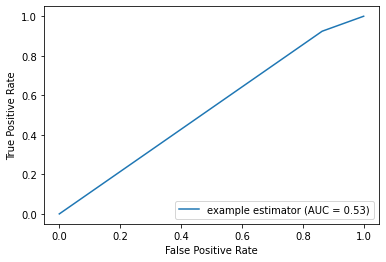

In [32]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='example estimator')
display.plot()

plt.show()

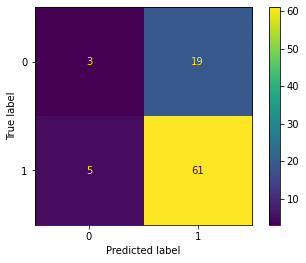

In [33]:
confusion = confusion_matrix(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm) 
disp.plot()
plt.show();

In [ ]:
# # to visualize pipeline
# set_config(display='diagram')
# pipeline

## Logistic Regression with gridsearch

In [43]:
pipeline = Pipeline(steps = [('all_features', all_features),
                     ("model", LogisticRegression())])

param_grid = {'all_features__categorical_pipeline__pca__n_components':[3,5,7],
              'all_features__numeric_pipeline__kbest__k': [1,2,3,4]}
              

grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_hyperparams = grid_search.best_params_
best_score = grid_search.best_score_

print(f'hyperparameters: {best_hyperparams}\n {best_score}')

X_test = X_test.dropna()
y_pred = grid_search.predict(X_test)

acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')
precision =  precision_score(y_test, y_pred, average='micro')

print(f'Test set accuracy: {acc}')
print(f'Test set recall: {recall}')
print(f'Precision: {precision}')

hyperparameters: {'all_features__categorical_pipeline__pca__n_components': 7, 'all_features__numeric_pipeline__kbest__k': 3}
 0.8153722334004024
Test set accuracy: 0.8295454545454546
Test set recall: 0.7045454545454546
Precision: 0.8295454545454546


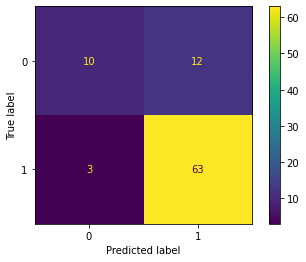

In [45]:
confusion = confusion_matrix(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm) 
disp.plot()
plt.show();

In [ ]:
# Or, save the HTML to a file
from sklearn.utils import estimator_html_repr

with open('images/model_pipeline.html', 'w') as f:  
    f.write(estimator_html_repr(pipeline))

### Random Forest

In [47]:
param_grid = {'all_features__categorical_pipeline__pca__n_components':[3,5,7,9,11],
              'all_features__numeric_pipeline__kbest__k': [1,2,3,4],
            'model__n_estimators': [100, 200,300, 500],
              'model__max_depth': [1,2, 3, 7, 10, 20]
             }

pipeline = Pipeline(steps = [('all_features', all_features),
                     ("model", RandomForestClassifier())])
              

grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_hyperparams = grid_search.best_params_
best_score = grid_search.best_score_

print(f'hyperparameters: {best_hyperparams}\n {best_score}')

X_test = X_test.dropna()
y_pred = grid_search.predict(X_test)

acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')
precision =  precision_score(y_test, y_pred, average='micro')

print(f'Test set accuracy: {acc}')
print(f'Test set recall: {recall}')
print(f'Precision: {precision}')

hyperparameters: {'all_features__categorical_pipeline__pca__n_components': 11, 'all_features__numeric_pipeline__kbest__k': 1, 'model__max_depth': 3, 'model__n_estimators': 200}
 0.809738430583501
Test set accuracy: 0.8295454545454546
Test set recall: 0.7045454545454546
Precision: 0.8295454545454546


In [ ]:
confusion = confusion_matrix(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm) 
disp.plot()
plt.show();

### Naive Bayes

In [48]:
pipeline = Pipeline(steps = [('all_features', all_features),
                     ("model",  GaussianNB())])

param_grid = {'all_features__categorical_pipeline__pca__n_components':[3,5,7,9,11],
              'all_features__numeric_pipeline__kbest__k': [1,2,3,4],
             }

          
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_hyperparams = grid_search.best_params_
best_score = grid_search.best_score_

print(f'hyperparameters: {best_hyperparams}\n {best_score}')

X_test = X_test.dropna()
y_pred = grid_search.predict(X_test)

acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')
precision =  precision_score(y_test, y_pred, average='micro')

print(f'Test set accuracy: {acc}')
print(f'Test set recall: {recall}')
print(f'Precision: {precision}')

hyperparameters: {'all_features__categorical_pipeline__pca__n_components': 7, 'all_features__numeric_pipeline__kbest__k': 2}
 0.7672434607645875
Test set accuracy: 0.8181818181818182
Test set recall: 0.7424242424242424
Precision: 0.8181818181818182


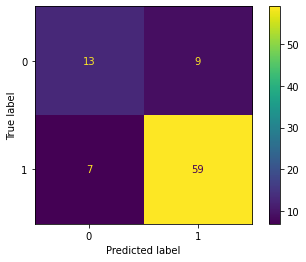

In [49]:
confusion = confusion_matrix(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm) #,display_labels=clf.classes_)
disp.plot()

plt.show()

In [ ]:
# importance = lr.coef_[0]

# for i,v in enumerate(importance):
#     print('Feature: %0d, Score: %.5f' % (i,v))

In [ ]:
# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import roc_curve
# logit_roc_auc = roc_auc_score(y_test_b, clf.predict(X_test_b))
# fpr, tpr, thresholds = roc_curve(y_test_b, clf.predict_proba(X_test_b)[:,1])
# plt.figure()
# plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic')
# plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
# plt.show()

## 6. Deploy your model to cloud and test it with PostMan, BASH or Python

In [ ]:
# Use one and many samples
# Docker 
# curl 
# pickle file?